In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# Image Classification Using CNN (second  classify (Tomato))
By : Amira Fathy

________


Data link : https://www.kaggle.com/datasets/sadmansakibmahi/plant-disease-expert


In [ ]:
## import libraries


In [ ]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
import glob as gb
from zipfile import ZipFile

In [ ]:
# the path of zip file

path_file= r'/content/drive/MyDrive/Colab Notebooks/tomato.zip'

In [ ]:
# extract zip file

with ZipFile(path_file,'r')as Zip:
  Zip.printdir()
  Zip.extractall()

In [ ]:
# path of image

data_path= r'/content/tomato'

# get the common size in images
# and the number of the images in each folder
Size=[]

for folder in os.listdir(data_path) :
    files = gb.glob(pathname= str( data_path +'/'+ folder + '/*.JPG'))
    print(f' found  {len(files)}  images in folder {folder}')
    for file in files:
        image = plt.imread(file)
        Size.append(image.shape)
pd.Series(Size).value_counts()

 found  1676  images in folder Tomato_Spider_mites_Two_spotted_spider_mite
 found  1590  images in folder Tomato_healthy
 found  1756  images in folder Tomato_Late_blight
 found  3208  images in folder Tomato__Tomato_YellowLeaf__Curl_Virus
 found  1771  images in folder Tomato_Septoria_leaf_spot
 found  2127  images in folder Tomato_Bacterial_spot
 found  1404  images in folder Tomato__Target_Spot
 found  952  images in folder Tomato_Leaf_Mold
 found  1000  images in folder Tomato_Early_blight
 found  373  images in folder Tomato__Tomato_mosaic_virus


(256, 256, 3)    15857
dtype: int64

The distribution  of images  not good  
 we have just 373 Tomato__Tomato_mosaic_virus

 and 952  Tomato_Leaf_Mold

In [ ]:
# initializing value
BATCH_SIZE = 256
IMAGE_SIZE = 150
CHANNELS=3
EPOCHS=50

In [ ]:
# load images  by keras
dataset =tf.keras.preprocessing.image_dataset_from_directory(data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [ ]:
# class names
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(256, 150, 150, 3)
[7 4 9 5 9 0 4 5 6 0 7 3 3 4 6 6 4 7 7 6 5 5 7 2 2 7 7 7 7 1 9 2 4 8 2 6 5
 5 4 7 2 4 6 2 4 5 2 6 0 1 5 5 3 1 0 5 6 1 4 7 0 0 0 6 1 3 4 2 2 2 7 6 0 7
 9 7 5 0 6 2 2 6 0 3 0 0 0 9 1 3 7 0 2 3 5 0 9 7 0 7 7 6 6 9 1 4 6 4 4 7 5
 2 0 3 4 0 7 7 7 9 9 5 7 0 9 3 9 9 6 2 0 0 4 3 6 2 5 7 0 3 5 2 6 1 6 4 5 0
 4 2 7 1 7 3 0 5 4 2 4 0 0 0 7 7 0 6 8 7 7 4 5 6 6 5 2 3 4 3 7 4 3 7 7 0 5
 5 7 3 4 5 7 6 7 6 6 0 7 5 5 2 7 4 7 2 7 9 3 4 2 5 5 4 2 6 2 2 4 4 1 2 0 1
 0 4 5 0 6 5 5 7 7 0 1 7 6 9 9 7 0 6 2 1 1 0 7 7 4 7 0 3 0 2 9 1 0 7]


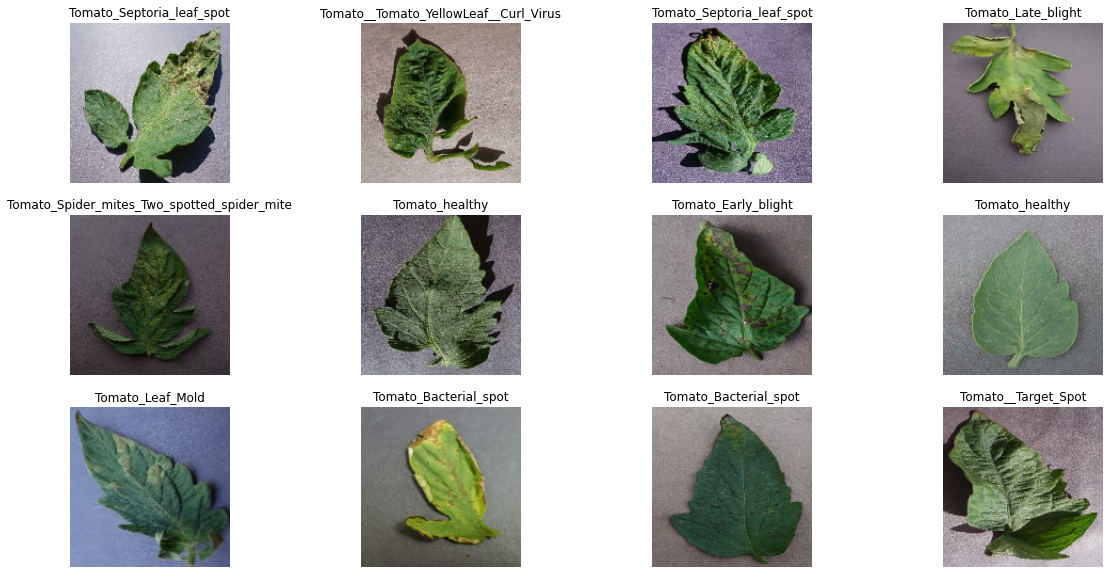

In [ ]:
# show some of image
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# len of  dataset
len(dataset)


63

In [ ]:
#  function to split data (train , test, validation)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
# split data
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(50, 6, 7)

In [ ]:
# to use the cpu & gpu
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# normalization data
# resize & rescale
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


In [ ]:
# data augmentation (ImageDataGenerator)
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)
#.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# bulid the CNN (Neural Network )
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 150, 150, 3)        0         
                                                                 
 conv2d_4 (Conv2D)           (256, 148, 148, 128)      3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (256, 74, 74, 128)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (256, 72, 72, 64)         73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (256, 36, 36, 64)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (256, 34, 34, 64)        

In [ ]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#train CNN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


In [ ]:
# acuuracy of the test
scores = model.evaluate(test_ds)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# show the  training & validation (accuracy & loss)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# the first image prdiction  vs the actual
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
# show some of image  ( the prediction  vs actual )& the confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
# save model
model.save("Tomato_cnn.h5")